In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from datetime import datetime
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
# import cdt

In [3]:
from IPython.display import Image, display

In [4]:
%load_ext rpy2.ipython

In [5]:
pd.set_option('display.max_rows', 100)

In [6]:
import numpy as np
import pandas as pd


def check_all_float(df: pd.DataFrame, columns: list):
    for col in columns:
        if not df[col].dtype == np.float64:
            raise ValueError(f"{col} is not a float")

In [7]:
# project_root = get_git_root()
project_root = Path('.')
data_folder = "data"
# datafile = "features.csv"
datafile = project_root / "features_v3.csv"
figsize = (10, 8)
font_graph = 10
font_color_graph = "black"

In [8]:
df = pd.read_csv(datafile, dtype={"D3": float})
# remove the ones for which even date is na
df = df.dropna(subset="day_survey")

In [9]:
num_prior_days = 10
date_covid = datetime(2020, 3, 1)
# rough date
date_vaccine = datetime(2021, 4, 1)

dem_dictionary = {
    'D1': 'gender',  # 1=M, 0=F
    'D2': 'white',  # 1=white or 0=non-white. 
    'D3': 'ios',  # 1=ios, 0=android
    'D4': 'cohort 2017',  # 1=2017, 0=2018
}

ema_dictionary = {
    "Y1": "pam",
    "Y2": "phq2_score",
    "Y3": "phq4_score",
    "Y4": "gad2_score",
    "Y5": "social_level",
    "Y6": "sse_score",
    "Y7": "stress",
}
reverse_ema_dictionary = {v: k for k, v in ema_dictionary.items()}

physical_dictionary = {
    "P1": "excercise",
    "P2": "studying",
    "P3": "in house",
    "P4": "sports",
}

social_dictionary = {
    "S1": "traveling",
    "S2": "distance traveled",
    "S3": "time in social location",
    "S4": "visits",
    "S5": "duration unlocked phone in social locations",
    "S6": "frequency of unlocked phone in social locations",
    "S7": "motion at social locations",
}

sleep_dictionary = {
    "Z1": "sleep_duration",
    "Z2": "sleep start time",
    "Z3": "sleep end time",
}

full_dictionary = (
    physical_dictionary | social_dictionary | sleep_dictionary | ema_dictionary | dem_dictionary
)

dem = list(dem_dictionary)
ema = list(ema_dictionary)
physical = list(physical_dictionary)
social = list(social_dictionary)
sleep = list(sleep_dictionary)

In [10]:
df["date"] = pd.to_datetime(df["day_survey"], format="%Y-%m-%d")
# pre-COVID
df = df.loc[df.date < date_covid]
df.rename(columns=reverse_ema_dictionary, inplace=True)
df.set_index(["uid", "date"], inplace=True)

In [11]:
len(df)

21321

In [12]:
df = df.loc[df.date < '2020-03-01 00:00:00']

AttributeError: 'DataFrame' object has no attribute 'date'

In [ ]:
len(df)

In [ ]:
df.set_index(["uid", "date"], inplace=True)

print(len(df))
df.dropna(subset=ema + physical + social + sleep, inplace=True)
df.dropna(subset=dem + ema + physical + social + sleep, inplace=True)
print(len(df))

In [ ]:
outcomes = ["Y4"]
# features = social
features = physical + social + sleep
subset = outcomes + features
draw_dictionary = {
    k: v for k, v in full_dictionary.items() if k in (outcomes + features)
}
df = df[subset]

In [141]:
node_to_feature = dict(zip(map(str, range(len(subset))), subset))
node_label_to_feature = dict(zip([f"X{i+1}" for i in range(len(subset))], subset))

In [142]:
check_all_float(df, subset)

In [18]:
df[subset].to_csv("features_dropna_prior20200301.csv", index=False)

In [ ]:
outcomes = ["Y1", "Y2", "Y3", "Y4", "Y5", "Y6", "Y7"]
features = dem + physical + social + sleep
subset = outcomes + features
df.dropna(subset=subset, inplace=True)
draw_dictionary = {
    k: v for k, v in full_dictionary.items() if k in (outcomes + features)
}
df = df[subset]

In [ ]:
len(df)

In [ ]:
check_all_float(df, subset)

In [13]:
df.to_csv(f"{datafile.stem}-dropna-precovid.csv")

## Run pcalg.pc

In [56]:
outcome = "Y7"

In [57]:
%%R -i outcome

library("pcalg")
library("glue")

data_full <- read.csv("features_v3-dropna-precovid.csv")
subset <- c("D1", "D2", "D3", "D4", "P1", "P2", "P3", "P4", "S1", "S2", "S3", "S4", "S5", "S6", "S7", "Z1", "Z2", "Z3", outcome)
data <- data_full[, subset]
n <- nrow(data)
p <- ncol(data)
indepTest <- gaussCItest
suffStat <- list(C=cor(data), n = n)

alpha <- 0.05
sink(glue("pc-results/fit-{outcome}.txt"))
pc.fit <- pc(suffStat, indepTest, labels = subset, alpha = alpha, verbose = TRUE, numCores = 8)
sink()

sink(glue("pc-results/edgelist-{outcome}.txt"))
showEdgeList(pc.fit, subset)
sink()

svg(glue("pc-results/CPDAG-{outcome}.svg"))
plot(pc.fit, main = glue("Estimated CPDAG for {outcome}"))
dev.off()

quartz_off_screen 
                2 


 追加情報:  警告メッセージ: 
 skeleton(suffStat, indepTest, alpha, labels = labels, method = skel.method,  で: 
  Argument numCores ignored: parallelization only available for method = 'stable.fast'


In [58]:
!zip -r pc-results.zip pc-results

updating: pc-results/ (stored 0%)
updating: pc-results/fit-Y6.txt (deflated 80%)
updating: pc-results/edgelist-Y5.txt (deflated 78%)
updating: pc-results/CPDAG-Y4.svg (deflated 82%)
updating: pc-results/CPDAG-Y5.svg (deflated 82%)
updating: pc-results/edgelist-Y4.txt (deflated 78%)
updating: pc-results/fit-Y7.txt (deflated 80%)
updating: pc-results/fit-Y5.txt (deflated 80%)
updating: pc-results/edgelist-Y6.txt (deflated 78%)
updating: pc-results/CPDAG-Y7.svg (deflated 82%)
updating: pc-results/CPDAG-Y6.svg (deflated 82%)
updating: pc-results/edgelist-Y7.txt (deflated 79%)
updating: pc-results/fit-Y4.txt (deflated 81%)
updating: pc-results/edgelist-Y3.txt (deflated 78%)
updating: pc-results/CPDAG-Y2.svg (deflated 82%)
updating: pc-results/CPDAG-Y3.svg (deflated 82%)
updating: pc-results/fit-Y1.txt (deflated 80%)
updating: pc-results/edgelist-Y2.txt (deflated 78%)
updating: pc-results/fit-Y3.txt (deflated 80%)
updating: pc-results/CPDAG-Y1.svg (deflated 82%)
updating: pc-results/fit-Y2.t

## Run dagitty

In [84]:
def create_dagitty(edgelist_file):
    with open(edgelist_file) as f:
        lines = f.readlines()
    
    directed_edges = []
    capture = False
    for line in lines:
        if 'Directed Edges:' in line:
            capture = True
            continue
        if capture and line.strip():
            directed_edges.append(line.strip().replace('  -->  ', ' -> '))
    
    output = "dag {\n" + "\n".join(directed_edges) + "\n}"
    return output

In [85]:
def parse_ici_output(ici_output):
    results = []
    for _, row in output.items():
        ici = dict(row)
        exposure = ici['X'][0]
        outcome = ici['Y'][0]
        if dict(ici['Z']):
            sets = ici['Z']
        else:
            sets = []
    
        results.append({
            "treatment": exposure,
            "outcome": outcome,
            "sets": sets,
        })
    
    return results

In [86]:
ici_results = []

In [105]:
outcome = "Y7"
dagitty_model = create_dagitty(f"pc-results/edgelist-{outcome}.txt")

In [106]:
%%R -i dagitty_model -o output
library(dagitty)
dag <- dagitty(dagitty_model)
# adjustmentSets(dag, exposure = exposure, outcome = treatment)
output = impliedConditionalIndependencies(dag)

In [107]:
ici_results += parse_ici_output(output)
len(ici_results)

2573

In [108]:
df_ici = pd.DataFrame(ici_results)

In [109]:
df_ici['set_length'] = df_ici['sets'].apply(len)

In [111]:
# df_ici.to_parquet("pc_ici.parquet", index=False)

In [112]:
df_ici = pd.read_parquet("pc_ici.parquet")

In [113]:
df_ici = df_ici.loc[df_ici.outcome.str.startswith("Y")].copy()

In [114]:
df_ici.outcome.value_counts()

outcome
Y2    60
Y5    53
Y6    51
Y4    31
Y1    29
Y3    27
Y7    26
Name: count, dtype: int64

In [115]:
df_ici

,treatment,outcome,sets,set_length
24,D2,Y1,"[D1, D3, P1, S2, S6, S7]",6
25,D2,Y1,"[D1, D3, D4, P1, S2, S4, S5, S7]",8
26,D2,Y1,"[D1, D3, D4, P1, S2, S3, S4, S7]",8
27,D2,Y1,"[D1, D3, D4, P1, P3, S2, S3, S4]",8
28,D2,Y1,"[D1, D3, D4, P1, P2, P3, P4, S1, S2]",9
...,...,...,...,...
2524,S6,Y7,"[D1, D3, D4, P1, P2, P3, P4, S1, S2, S7]",10
2525,S6,Y7,"[D1, D2, D3, D4, P2, P3, S1, S2, S3, S4]",10
2526,S6,Y7,"[D1, D2, D3, D4, P2, P4, S1, S2, S3, S4]",10
2527,S6,Y7,"[D1, D3, D4, P1, S2, S3, S4]",7


In [116]:
df_ici_longest = df_ici.loc[df_ici.groupby(['treatment', 'outcome'])['set_length'].idxmax()].sort_values(by=['outcome', 'treatment']).reset_index(drop=True)

In [120]:
df_ici_longest.to_parquet("pc_ici_longest.parquet")

In [121]:
df_ici_longest

,treatment,outcome,sets,set_length
0,D2,Y1,"[D1, D3, D4, P1, P2, P3, P4, S1, S2]",9
1,D4,Y1,"[D1, D3, P1, S2, S6, S7]",6
2,P2,Y1,"[D1, D3, D4, P1, S2, S4, S5, S7]",8
3,P3,Y1,"[D1, D2, D3, D4, P2, P4, S1, S2, S3, S4, S7]",11
4,P4,Y1,"[D1, D2, D3, D4, P1, P2, P3, S1, S3, S4]",10
5,S1,Y1,"[D2, D3, P1, P2, P3, P4, S2, S3, S4]",9
6,S3,Y1,"[D1, D3, D4, P1, S2, S4, S5, S7]",8
7,S4,Y1,"[D1, D3, P1, S2, S6, S7]",6
8,S5,Y1,"[D1, D3, D4, P1, S2, S3, S4, S6]",8
9,D1,Y2,"[D2, D3, D4, P3, S2, S4, S6, S7]",8


In [98]:
import re

# stdout pattern of pcalg.pc or pcalg.fic
pattern = r"x= (\d+)  y= (\d+)  S= ((?:\d+ ?)*) : pval = ([\d.e-]+)"

# with open("output-pcfit.txt") as f:
with open("pc-results/fit.txt") as f:
    matches = re.findall(pattern, f.read())

df = pd.DataFrame(matches, columns=["x", "y", "S", "pval"])
df = df.astype({"x": int, "y": int, "S": object, "pval": float})

In [99]:
df['S'] = df.S.apply(lambda x: x.split())

In [100]:
df['order'] = df.S.apply(len)

In [101]:
df.order.value_counts().to_frame().sort_values(by="order")

,count
order,
0,197
1,1710
2,3789
3,3272
4,1795
5,1110
6,434
7,96
8,9


In [104]:
len(df)

12412

In [83]:
num_to_name = dict(zip(range(1, len(subset) + 1), subset))
name_to_num = {v:k for k,v in num_to_name.items()}

In [269]:
df['x'] = df.x.map(num_to_name)
df['y'] = df.y.map(num_to_name)

In [270]:
df['S'] = df.S.apply(lambda x: [num_to_name[int(each)] for each in x])

In [271]:
df = df.loc[df.y == outcome]

In [272]:
df

,x,y,S,pval,order
13,P1,Y4,[],5.561850e-02,0
27,P2,Y4,[],6.383065e-01,0
41,P3,Y4,[],5.877693e-07,0
55,P4,Y4,[],2.069098e-02,0
69,S1,Y4,[],6.353654e-04,0
...,...,...,...,...,...
12392,S4,Y4,"[P1, P2, S1, S3, S6, S7, Z3]",1.050763e-45,7
12393,S4,Y4,"[P1, P4, S1, S3, S6, S7, Z3]",5.463546e-42,7
12394,S4,Y4,"[P2, P4, S1, S3, S6, S7, Z3]",3.985276e-37,7
12402,Z2,Y4,"[P3, P4, S5, S6, S7, Z1, Z3]",1.319328e-31,7


In [273]:
df.loc[df.S.apply(lambda x: set(x) == set(['P4', 'S1', 'S4', 'S7', 'Z2']))]

,x,y,S,pval,order


In [274]:
# print(f"all: {len(df)}")
# for i in range(1000):
#     p = i * 0.001
#     count = len(df.loc[df.pval >= p])
#     print(f"[p >= {p:.3f}] {count}")
#     if count == 0:
#         break

In [196]:
pval_threshold = 0.001

In [197]:
df = df.loc[df.pval >= pval_threshold]

In [198]:
df.head()

,x,y,S,pval,order
13,P1,Y4,[],0.055619,0
27,P2,Y4,[],0.638306,0
55,P4,Y4,[],0.020691,0
96,S3,Y4,[],0.008770,0
123,S5,Y4,[],0.178115,0


In [199]:
df.head()

,x,y,S,pval,order
13,P1,Y4,[],0.055619,0
27,P2,Y4,[],0.638306,0
55,P4,Y4,[],0.020691,0
96,S3,Y4,[],0.008770,0
123,S5,Y4,[],0.178115,0


In [200]:
# for _, row in df.iterrows():
#     print(row.x)

# causal-learn

In [58]:
import networkx as nx
import matplotlib.pyplot as plt

In [59]:
def causalgraph_to_networkx(causal_graph):
    # Create an empty directed graph
    G = nx.DiGraph()

    # Add nodes from the CausalGraph
    for node in causal_graph.get_nodes():
        G.add_node(node_label_to_feature[node.name])

    # Add edges from the CausalGraph
    for edge in causal_graph.get_graph_edges():
        source = node_label_to_feature[edge.node1.name]
        target = node_label_to_feature[edge.node2.name]
        G.add_edge(source, target)

    return G

## PC

https://causal-learn.readthedocs.io/en/latest/search_methods_index/Constraint-based%20causal%20discovery%20methods/PC.html

In [60]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.Edge import Edge
from causallearn.graph.GraphNode import GraphNode
from causallearn.graph.Dag import Dag

In [68]:
cg = pc(df.values)

  0%|          | 0/20 [00:00<?, ?it/s]

In [69]:
# cg.draw_pydot_graph()

In [70]:
pyd = GraphUtils.to_pydot(cg.G)

In [95]:
num_to_name = dict(zip(map(str, range(len(subset))), subset))

for node in pyd.get_nodes():
    label = num_to_name[node.get_name()]
    label = draw_dictionary[label]
    node.set_label(label)

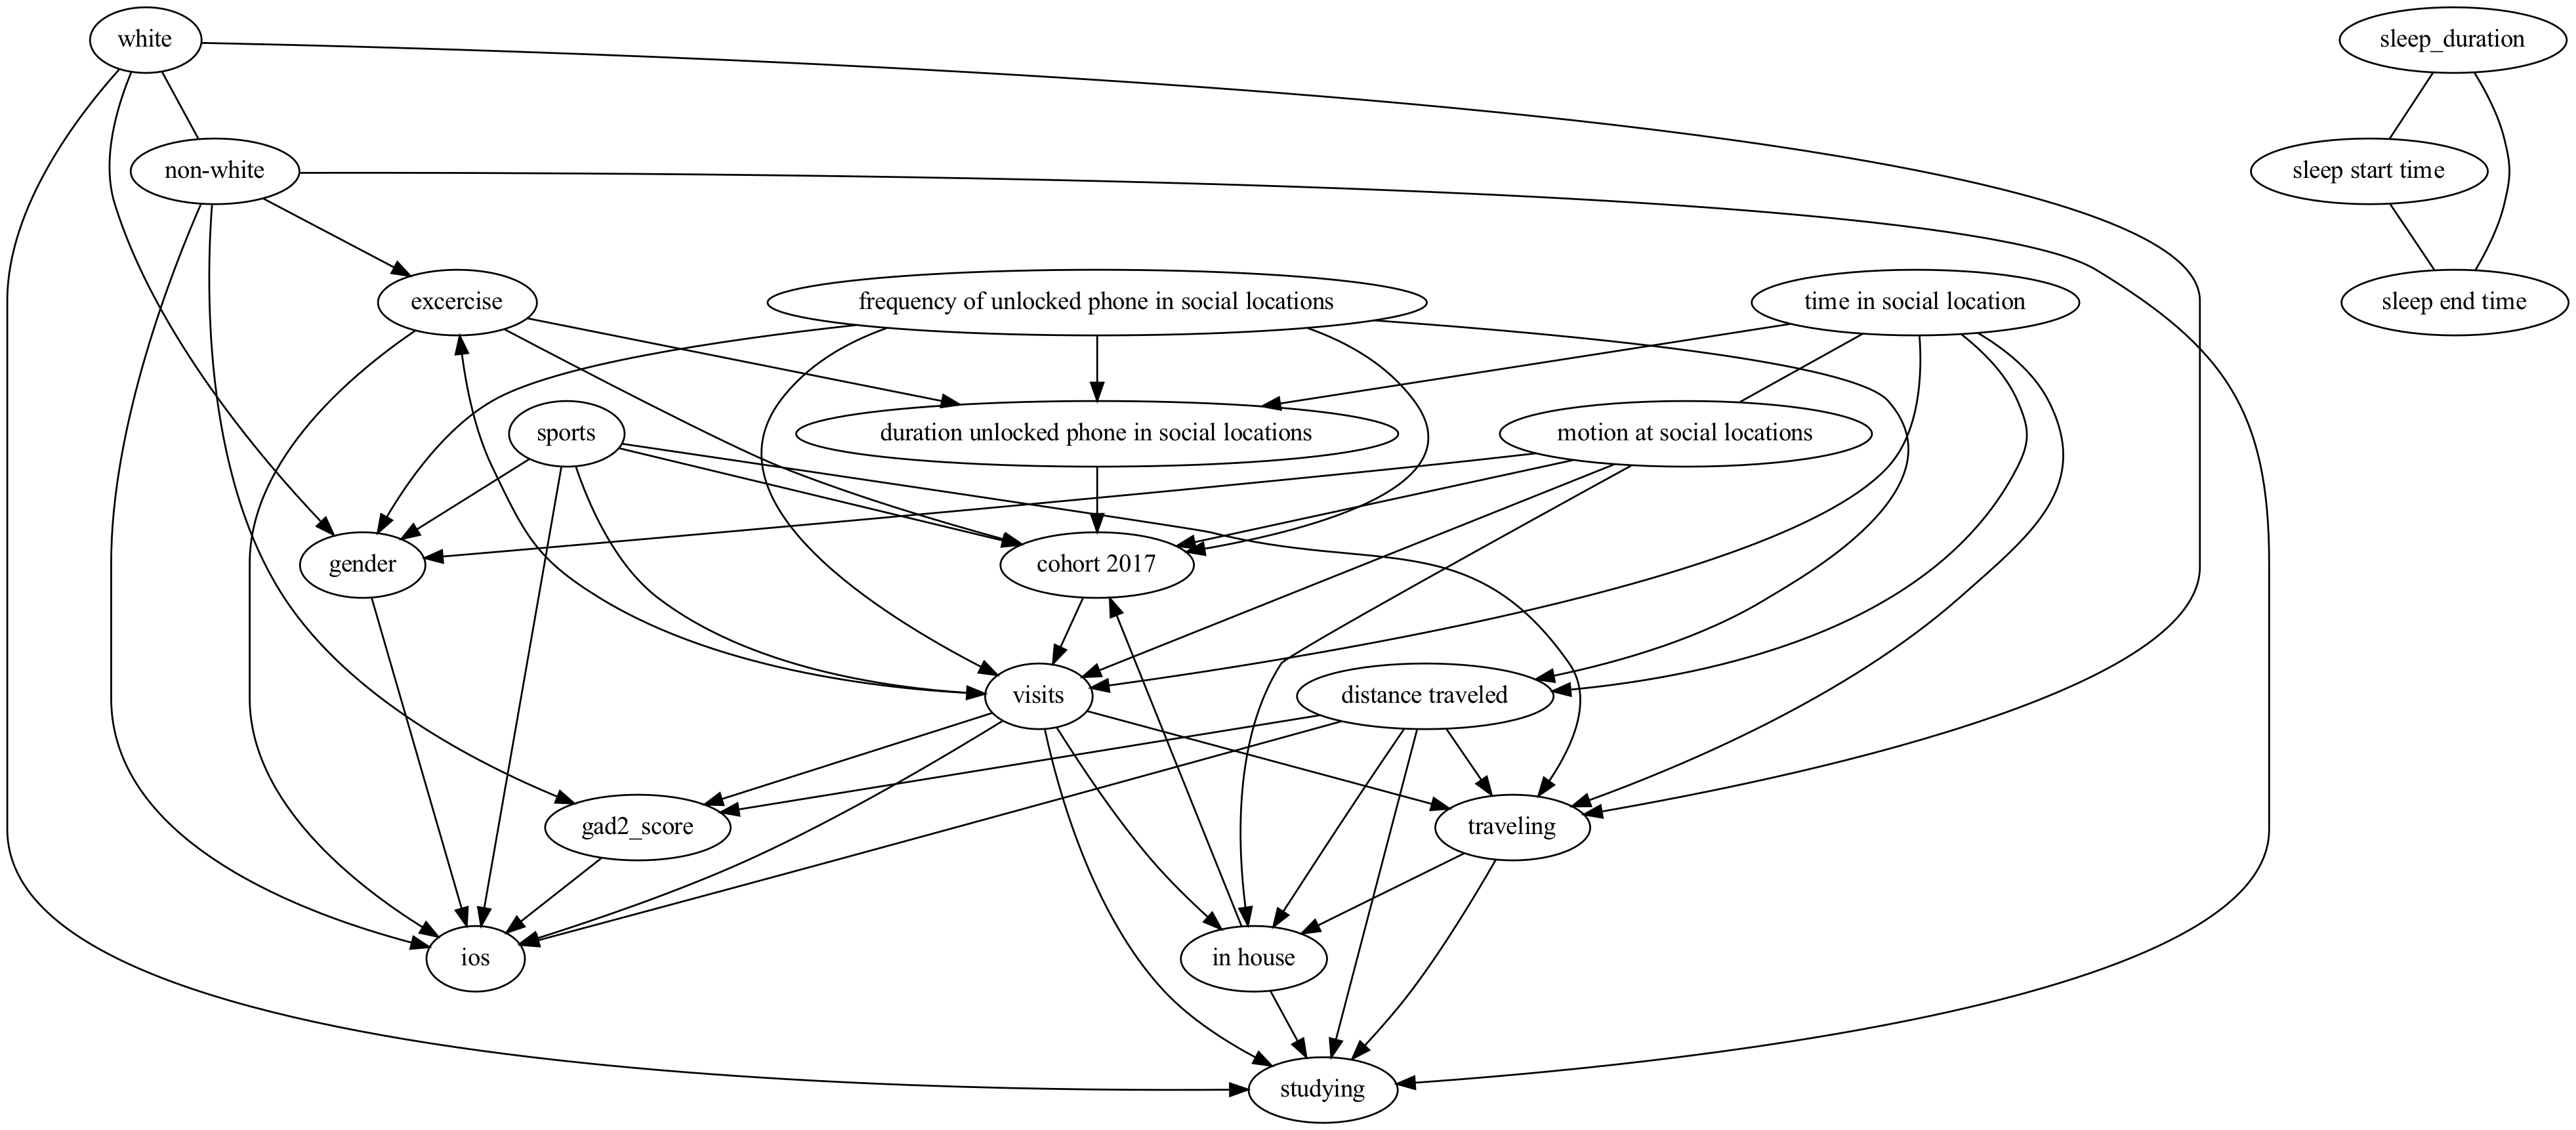

In [96]:
Image(pyd.create_png())

In [56]:
nxG.edges

OutEdgeView([('P2', 'P1'), ('P2', 'S1'), ('P3', 'P2'), ('P4', 'P2'), ('P4', 'S1'), ('P4', 'S4'), ('S1', 'P1'), ('S1', 'P3'), ('S1', 'S2'), ('S1', 'S4'), ('S2', 'Y4'), ('S2', 'P1'), ('S2', 'P2'), ('S2', 'P3'), ('S2', 'S3'), ('S3', 'S1'), ('S4', 'Y4'), ('S4', 'P1'), ('S4', 'P2'), ('S4', 'S3'), ('S5', 'P1'), ('S5', 'S3'), ('S5', 'S6'), ('S6', 'S2'), ('S6', 'S3'), ('S6', 'S4'), ('S7', 'Y4'), ('S7', 'P1'), ('S7', 'P3'), ('S7', 'S3'), ('S7', 'S4'), ('Z1', 'Z2'), ('Z1', 'Z3'), ('Z2', 'Z3')])

In [57]:
list(nx.simple_cycles(nxG))

[['S2', 'P2', 'S1'],
 ['S2', 'P3', 'P2', 'S1'],
 ['S2', 'S3', 'S1'],
 ['P2', 'S1', 'P3'],
 ['P2', 'S1', 'S4'],
 ['S3', 'S1', 'S4']]

In [276]:
pyd.write_png('pc.png')

In [18]:
# !open pc.png

In [19]:
# def identify_confounds(dag, treatment, outcome):
#     parents_of_treatment = set()
#     children_of_treatment = set()
#     for edge in dag.get_graph_edges():
#         if edge.get_node1().get_name() == treatment and edge.get_endpoint1() == 1:
#             parents_of_treatment.add(edge.get_node2().get_name())
#         elif edge.get_node2().get_name() == treatment and edge.get_endpoint2() == 1:
#             parents_of_treatment.add(edge.get_node1().get_name())
#         if edge.get_node1().get_name() == treatment and edge.get_endpoint2() == 2:
#             children_of_treatment.add(edge.get_node2().get_name())
#         elif edge.get_node2().get_name() == treatment and edge.get_endpoint1() == 2:
#             children_of_treatment.add(edge.get_node1().get_name())
#     potential_confounds = parents_of_treatment.union(children_of_treatment)
#     if outcome in potential_confounds:
#         potential_confounds.remove(outcome)
#     return list(potential_confounds)

In [20]:
# # Step 2: Identify Paths and Check for Backdoor Paths
# def find_backdoor_paths(dag, exposure, outcome):
#     backdoor_paths = []
#     for path in nx.all_simple_paths(dag.to_undirected(), source=exposure, target=outcome):
#         if path[1] not in dag.successors(exposure):  # Ensure it's a backdoor path
#             backdoor_paths.append(path)
#     return backdoor_paths

# # Step 3: Use d-separation to Determine Confounders
# def is_d_separated(dag, exposure, outcome, conditioning_set):
#     undirected_dag = dag.to_undirected()
#     for path in nx.all_simple_paths(undirected_dag, source=exposure, target=outcome):
#         if all(node in conditioning_set for node in path[1:-1]):
#             continue  # Path is blocked by conditioning set
#         else:
#             return False  # Path is not blocked
#     return True

# def identify_confounders(dag, exposure, outcome):
#     potential_confounders = set()
#     backdoor_paths = find_backdoor_paths(dag, exposure, outcome)
    
#     for path in backdoor_paths:
#         for node in path:
#             if node != exposure and node != outcome:
#                 potential_confounders.add(node)
    
#     confounders = []
#     for confounder in potential_confounders:
#         if not is_d_separated(dag, exposure, outcome, {confounder}):
#             confounders.append(confounder)
    
#     return confounders

In [22]:
# # https://medium.com/@causalwizard/how-to-detect-collider-and-mediator-variables-using-python-and-networkx-59ac44826a8e

# def get_mediators(
#     G : nx.Graph,
#     treatment,
#     outcome,
# ):
#     outcome_ancestors = set(nx.ancestors(G, source=outcome))
#     treatment_descendants = set(nx.descendants(G, source=treatment))
#     mediators = treatment_descendants.intersection(outcome_ancestors)
#     return mediators


# def get_colliders(
#     G : nx.Graph, 
#     treatment, 
#     outcome,
# ):
#     outcome_descendants = set(nx.descendants(G, source=outcome))
#     treatment_descendants = set(nx.descendants(G, source=treatment))
#     possible_colliders = outcome_descendants.intersection(treatment_descendants)
#     # print(possible_colliders)
    
#     colliders = []
#     for possible_collider in possible_colliders:
#         paths = nx.all_simple_paths(G, treatment, possible_collider)
#         for path in paths:
#             if not outcome in path:
#                 colliders.append(possible_collider)
#                 break  # avoid duplicates
#     return colliders


# for treatment in features:
#     # colliders = get_colliders(nxG, treatment, outcomes[0])
#     colliders = get_colliders(nxG, treatment, "S4")
#     print(f"[{treatment}] Colliders:", colliders)

In [23]:
# for treatment in features:
#     # confounders = identify_confounders(cg.G, treatment, outcomes[0])
#     confounders = identify_confounders(nxG, treatment, outcomes[0])
#     print(f"[{treatment}] Confounders to adjust for:", confounders)

In [24]:
# # Prepare the data for regression
# X = data[[treatment] + confounders]
# X = sm.add_constant(X)  # Adds a constant term to the model
# Y = data[outcome]
# # Fit the regression model
# model = sm.OLS(Y, X).fit()
# # Summary of the model
# print(model.summary())
# # Extract the ACE
# ace = model.params[treatment]
# print("Average Causal Effect (ACE) of {} on {}: {}".format(treatment, outcome, ace))

## FCI

https://causal-learn.readthedocs.io/en/latest/search_methods_index/Constraint-based%20causal%20discovery%20methods/FCI.html

In [206]:
g, edges = fci(df.values)

  0%|          | 0/15 [00:00<?, ?it/s]

KeyError: (1, 4)

In [ ]:
pyd = GraphUtils.to_pydot(g)

In [ ]:
for node in pyd.get_nodes():
    label = node_to_feature[node.get_name()]
    label = draw_dictionary[label]
    node.set_label(label)

In [ ]:
Image(pyd.create_png())

In [ ]:
pyd.write_png('fci.png')

In [79]:
# !open fci.png

In [ ]:
import pandas as pd
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.GraphUtils import GraphUtils
import numpy as np
import statsmodels.api as sm

In [ ]:
# Get the graph
dag = fci_result[0]
# Visualize the DAG (optional, requires pydot and graphviz)
GraphUtils.to_pydot(dag).write_png('fci_dag.png')
# Define treatment and outcome variables
treatment = 'X'
outcome = 'Y'
# Identify covariates that need to be adjusted for
def identify_confounds(dag, treatment, outcome):
    parents_of_treatment = set()
    children_of_treatment = set()
    for edge in dag.get_graph_edges():
        if edge.get_node1().get_name() == treatment and edge.get_endpoint1() == 1:
            parents_of_treatment.add(edge.get_node2().get_name())
        elif edge.get_node2().get_name() == treatment and edge.get_endpoint2() == 1:
            parents_of_treatment.add(edge.get_node1().get_name())
        if edge.get_node1().get_name() == treatment and edge.get_endpoint2() == 2:
            children_of_treatment.add(edge.get_node2().get_name())
        elif edge.get_node2().get_name() == treatment and edge.get_endpoint1() == 2:
            children_of_treatment.add(edge.get_node1().get_name())
    potential_confounds = parents_of_treatment.union(children_of_treatment)
    if outcome in potential_confounds:
        potential_confounds.remove(outcome)
    return list(potential_confounds)
confounders = identify_confounds(dag, treatment, outcome)
print("Confounders to adjust for:", confounders)
# Prepare the data for regression
X = data[[treatment] + confounders]
X = sm.add_constant(X)  # Adds a constant term to the model
Y = data[outcome]
# Fit the regression model
model = sm.OLS(Y, X).fit()
# Summary of the model
print(model.summary())
# Extract the ACE
ace = model.params[treatment]
print("Average Causal Effect (ACE) of {} on {}: {}".format(treatment, outcome, ace))

# DoWhy

In [22]:
def create_graph(edgelist_text):
    
    # Create an empty directed graph
    G = nx.DiGraph()
    
    # Parse the edge list
    edges = [line.strip().split('  -->  ') for line in edgelist_text.strip().split('\n')]
    
    # Add edges to the graph
    for edge in edges:
        G.add_edge(edge[0], edge[1])
    
    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    plt.show()

    return G

In [23]:
from dowhy import gcm
from dowhy import CausalModel

In [103]:
edgelist = """\
  P1  -->  P2 
  P1  -->  S1 
  P1  -->  S2 
  P1  -->  S4 
  P1  -->  S5 
  P1  -->  S7 
  P2  -->  P3 
  P2  -->  P4 
  P2  -->  S1 
  P2  -->  S2 
  P2  -->  S4 
  P3  -->  S1 
  P3  -->  S2 
  P3  -->  S7 
  P3  -->  Z1 
  P3  -->  Z2 
  P4  -->  S1 
  P4  -->  S4 
  P4  -->  Z2 
  P4  -->  Z3 
  S1  -->  S2 
  S1  -->  S3 
  S1  -->  S4 
  S1  -->  Z3 
  S2  -->  S3 
  S2  -->  S6 
  S2  -->  Z1 
  S2  -->  Y4 
  S3  -->  S4 
  S3  -->  S5 
  S3  -->  S7 
  S4  -->  S6 
  S4  -->  S7 
  S4  -->  Z3 
  S4  -->  Y4 
  S5  -->  S6 
  S5  -->  Z2 
  S6  -->  Z1 
  S6  -->  Z2 
  S7  -->  Z1 
  S7  -->  Z2 
  S7  -->  Y4 
  Z1  -->  Z2 
  Z1  -->  Z3 
  Z1  -->  Y4 
  Z2  -->  Z3 
  Z2  -->  Y4
"""

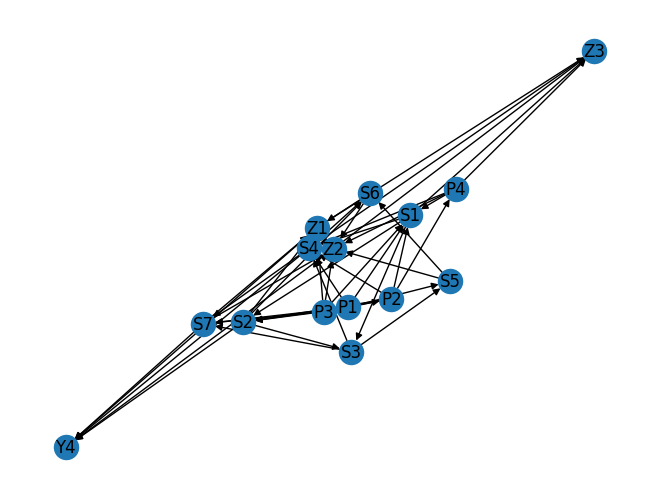

In [104]:
G = create_graph(edgelist)

In [174]:
model = CausalModel(
    data=df,
    treatment="P4",
    outcome="Y4",
    graph=G
)

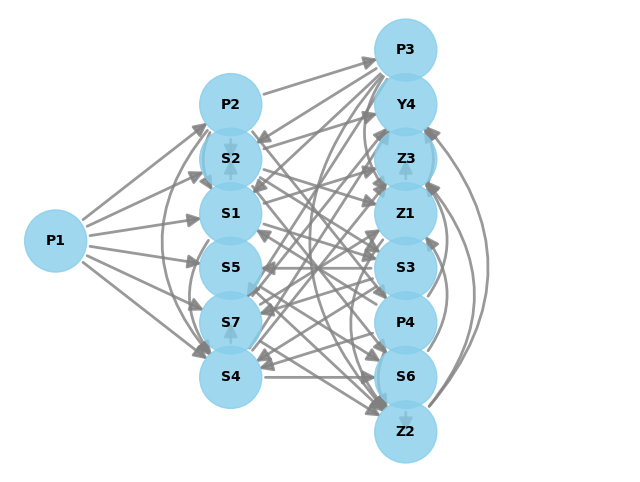

In [175]:
model.view_model()

In [182]:
# identified_estimand = model.identify_effect()

# direct effect?
identified_estimand = model.identify_effect(
    proceed_when_unidentifiable=True,
)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[Y4|P2])
d[P₄]          
Estimand assumption 1, Unconfoundedness: If U→{P4} and U→Y4 then P(Y4|P4,P2,U) = P(Y4|P4,P2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [183]:
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True
)
print("Average Treatment Effect (ATE): ", causal_estimate.value)

Average Treatment Effect (ATE):  -0.03587289368905322


In [184]:
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[Y4|P2])
d[P₄]          
Estimand assumption 1, Unconfoundedness: If U→{P4} and U→Y4 then P(Y4|P4,P2,U) = P(Y4|P4,P2)

## Realized estimand
b: Y4~P4+P2+P4*P3
Target units: 

## Estimate
Mean value: -0.03587289368905322
p-value: [0.00810545]
### Conditional Estimates
__categorical__P3
(-0.001, 7.613]    -0.083752
(7.613, 10.178]    -0.048712
(10.178, 12.088]   -0.032568
(12.088, 14.126]   -0.018020
(14.126, 21.606]    0.003691
dtype: float64


In [179]:
# Refute the obtained estimate to check the robustness
refutation = model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter")
print(refutation)

/Users/thama/Downloads/StudentLife/.venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/thama/Downloads/StudentLife/.venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/thama/Downloads/StudentLife/.venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/thama/Downloads/StudentLife/.venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/thama/Downloads/StudentLife/.venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divid

Refute: Use a Placebo Treatment
Estimated effect:-0.03587289368905322
New effect:0.0
p value:1.0



In [31]:
causal_model = gcm.StructuralCausalModel(G)

In [71]:
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, df)

In [73]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node